In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics
from AdaptiveALMA import AdaptiveALMA

from river import stream, compose
from river import preprocessing
from river import linear_model as ln
from river import multiclass

%matplotlib inline

In [2]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Number of samples  %s' % Counter(df['Label']))
X1 = df.drop(['Label'], axis=1)
y1 = df['Label']
X1, y1 = shuffle(X1, y1, random_state=42)

Number of samples  Counter({0: 14269, 1: 1124})


In [3]:
data = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Number of samples  %s' % Counter(df['Label']))
X2 = data.drop(['Label'], axis=1)
y2 = data['Label']
X2, y2 = shuffle(X2, y2, random_state=42)

Number of samples  Counter({0: 14269, 1: 1124})


In [4]:
spoof = stream.iter_pandas(X1, y1)
alteration = stream.iter_pandas(X2, y2)

In [5]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [6]:
from river.metrics import Accuracy
from collections import defaultdict

def process1(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Alteration:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices, performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Spoofing')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Spoofing and Alteration of the EHMS Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_EHMS_Classes_1.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Spoofing:
Class 0: 0.5236526736281449
Class 1: 0.5088967971530249
Accuracies after processing Alteration:
Class 0: 0.6201205410330086
Class 1: 0.7155425219941349


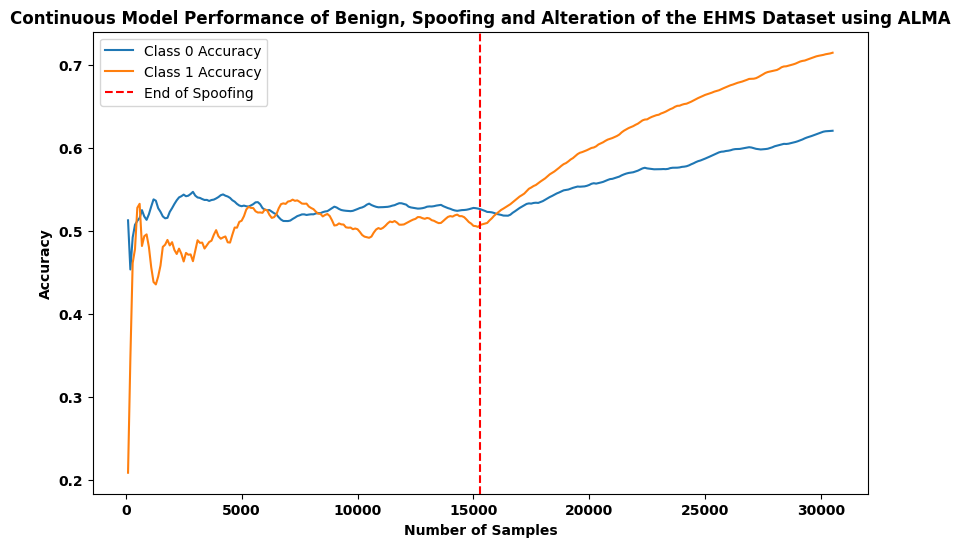

In [7]:
# Process the first dataset
indices, performances = process1(spoof, alteration)

In [8]:
spoof = stream.iter_pandas(X1, y1)
alteration = stream.iter_pandas(X2, y2)

In [9]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

In [10]:
from river.metrics import Accuracy
from collections import defaultdict

def process1(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Alteration:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices, performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Spoofing')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Spoofing and Alteration of the EHMS Dataset using Adaptive ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('Adaptive_ALMA_EHMS_Classes_1.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Spoofing:
Class 0: 0.6576494498563319
Class 1: 0.32473309608540923
Accuracies after processing Alteration:
Class 0: 0.6542504730534726
Class 1: 0.20087976539589442


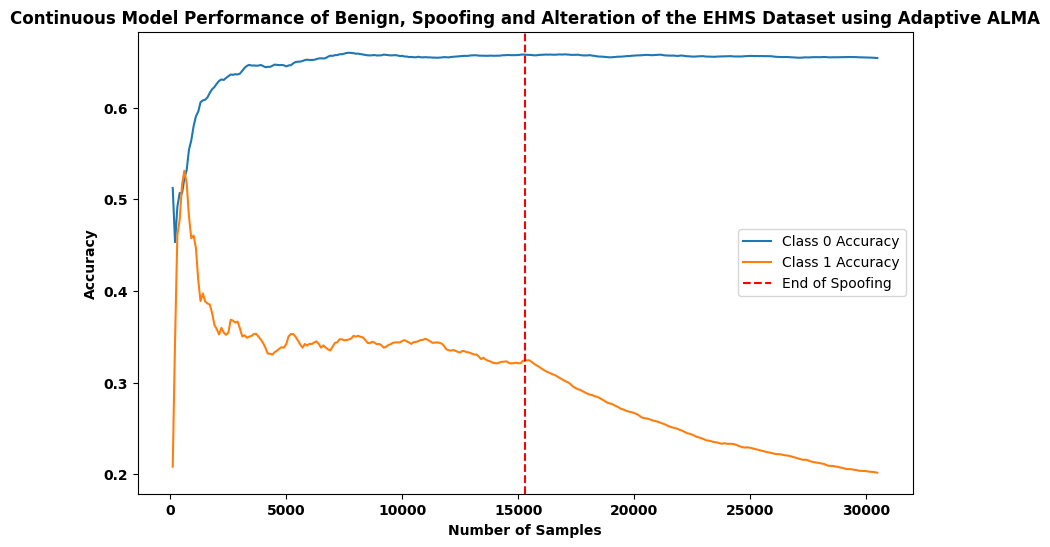

In [11]:
# Process the first dataset
indices, performances = process1(spoof, alteration)

In [12]:
spoof = stream.iter_pandas(X1, y1)
alteration = stream.iter_pandas(X2, y2)

In [13]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [14]:
from river.metrics import Accuracy
from collections import defaultdict

def process2(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Alteration:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices, performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Alteration')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Alteration and Spoofing of the EHMS Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_EHMS_Classes_2.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Alteration:
Class 0: 0.7882122082836919
Class 1: 0.9479392624728851
Accuracies after processing Spoofing:
Class 0: 0.7705515453080104
Class 1: 0.5557184750733137


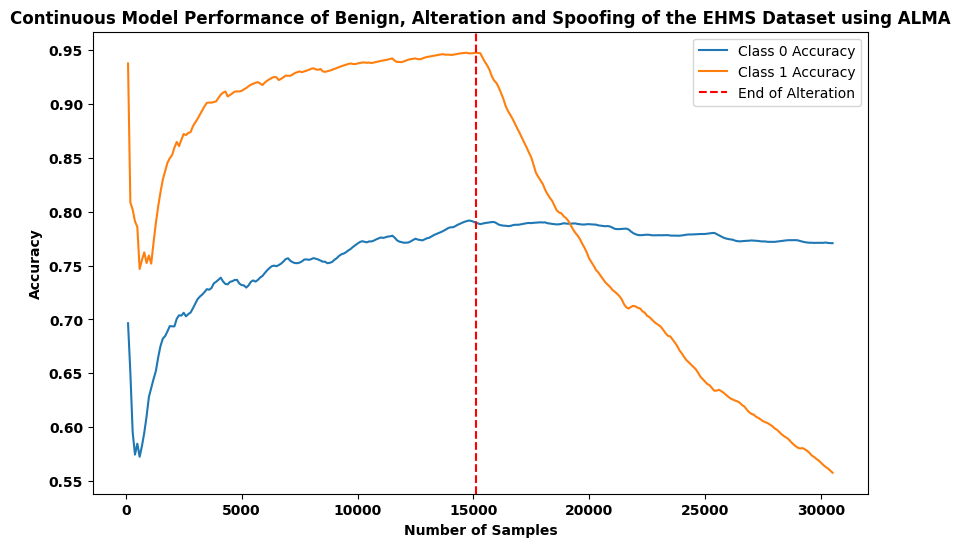

In [15]:
# Process the first dataset
indices, performances = process2(alteration, spoof)

In [16]:
spoof = stream.iter_pandas(X1, y1)
alteration = stream.iter_pandas(X2, y2)

In [17]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

In [18]:
from river.metrics import Accuracy
from collections import defaultdict

def process2(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Alteration:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                performances[key].append(average_accuracy)
                temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Spoofing:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices, performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Alteration')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Alteration and Spoofing of the EHMS Dataset using Adaptive ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('Adaptive_ALMA_EHMS_Classes_2.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Alteration:
Class 0: 0.8684560936295466
Class 1: 0.9837310195227765
Accuracies after processing Spoofing:
Class 0: 0.8649169528348167
Class 1: 0.533724340175953


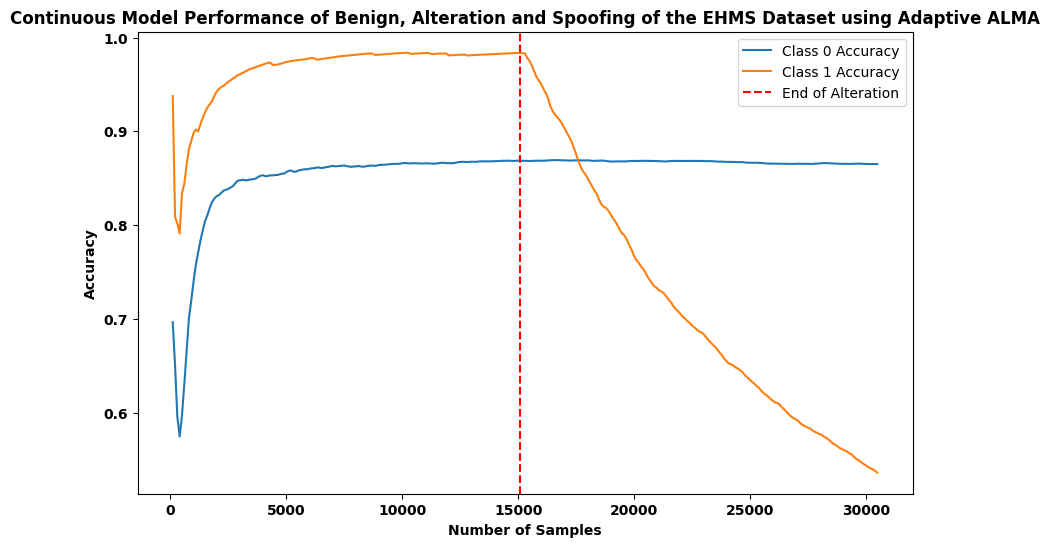

In [19]:
# Process the first dataset
indices, performances = process2(alteration, spoof)

In [20]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Number of samples  %s' % Counter(df['Label']))
X1 = df.drop(['Label'], axis=1)
y1 = df['Label']
X1, y1 = shuffle(X1, y1, random_state=42)
dataset = stream.iter_pandas(X1, y1)

Number of samples  Counter({0: 14269, 1: 1124})


In [21]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [22]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=10000)

[10,000] F1: 12.94%
[15,393] F1: 13.47%
CPU times: user 1.69 s, sys: 22.8 ms, total: 1.71 s
Wall time: 1.56 s


F1: 13.47%

In [23]:
dataset = stream.iter_pandas(X1, y1)

In [24]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [25]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=10000)

[10,000] F1: 11.78%
[15,393] F1: 11.45%
CPU times: user 1.64 s, sys: 20.2 ms, total: 1.66 s
Wall time: 1.65 s


F1: 11.45%

In [26]:
data = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Number of samples  %s' % Counter(df['Label']))
X2 = data.drop(['Label'], axis=1)
y2 = data['Label']
X2, y2 = shuffle(X2, y2, random_state=42)
dataset = stream.iter_pandas(X2, y2)

Number of samples  Counter({0: 14269, 1: 1124})


In [27]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [28]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=10000)

[10,000] F1: 34.38%
[15,191] F1: 36.28%
CPU times: user 1.5 s, sys: 12.9 ms, total: 1.51 s
Wall time: 1.53 s


F1: 36.28%

In [29]:
dataset = stream.iter_pandas(X2, y2)

In [30]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [31]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=10000)

[10,000] F1: 48.70%
[15,191] F1: 48.95%
CPU times: user 1.6 s, sys: 11 ms, total: 1.61 s
Wall time: 1.62 s


F1: 48.95%